# Battle of neighborhoods

## Find the best Mexican restaurants

### Introduction/Business Problem

New York is the restaurant capital of the world. Just consider there are 24,000 eating establishments in Manhattan alone.
Opening a New York City restaurant takes daring, talent, and investors. While the fine-dining stalwarts continue to thrive, the heart of the market right now is food with immigrant roots. From casual Chinese in the East Village to home-style Indian in Queens and Michelin-star Mexican in Brooklyn. 

According to a recent study of American eating preferences by YouGov, the British-based market research and data analytics company, it’s our second-favorite international cuisine, after Italian. Further evidence is given by DoorDash, the nation’s number-one food delivery service, which revealed that some Mexican dishes are among 2019’s 15 most popular food orders in America.

This report explores which neighborhoods and boroughs of New York City have the most as well as the best Mexican restaurants. Additionally, I will attempt to answer the questions “Where should I open a Mexican Restaurant?” and “Where should I stay if I want great Mexican food?”

**Data**

Data In order to answer the above questions, data on New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tips are required.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset

New York City data containing neighborhood boundaries will be obtained from the data source: https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

All data related to locations and quality of Mexican restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

**Methodology**

Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

FourSquare be used to locate all venues and then filtered by French restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

Data will be sorted based on rankings.

Finally, the data be will be visually assessed using graphing from various Python libraries.

In [2]:
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
%matplotlib inline

In [3]:
# Foussquare Credentials

CLIENT_ID = 'RCMR3USSC4RFHQ4H5AQ4YSOXFRHSCXGO13XC30GN4DO4DFLR' # your Foursquare ID
CLIENT_SECRET = 'OBIOSSDFYTLPVMXWE4R0VCWHFKI32C3NOUEA1UNKKGGMLRRM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define getting data functions

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Get data

In [9]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
ny_data.shape

(306, 4)

### Exploratory Analysis

**Neighborhoods per borough**

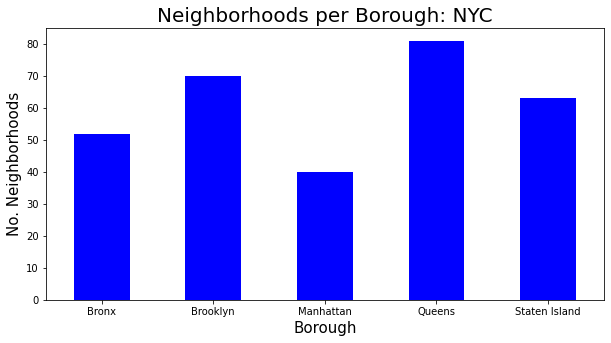

In [11]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize = (10,5), color = clr)

plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

Prepare neighborhood list that contains Mexican resturants

In [52]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
mexican_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    mexican_restaurants=venues[venues['Category']=='Mexican Restaurant']   
    print('(',count,'/',len(ny_data),')','Mexican Resturants in '+Neighborhood+', '+Borough+':'+str(len(mexican_restaurants)))
    print(row)
    for restaurant_detail in mexican_restaurants.values.tolist():
        id, name , category=restaurant_detail
        mexican_rest_ny = mexican_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Mexican Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Mexican Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Mexican Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Mexican Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Mexican Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Mexican Resturants in Kingsbridge, Bronx:3
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Mexican Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Mexican Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Mexican Resturants in Norwood, Bronx:0
['Bronx', '

Save the french restaurants file

In [53]:
mexican_rest_ny.to_csv('mexican_rest')

In [54]:
mexican_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V
1,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant
2,Bronx,Kingsbridge,553d5376498e322eb4d37a1b,Chipotle Mexican Grill
3,Bronx,Bedford Park,4bab9998f964a520c8b73ae3,OK Mr. Pancho
4,Bronx,Fordham,5692ecc0498e4b7de670f1ec,Elias' Cinco De Mayo


In [55]:
mexican_rest_ny.shape

(136, 4)

Mexican restaurants per borough

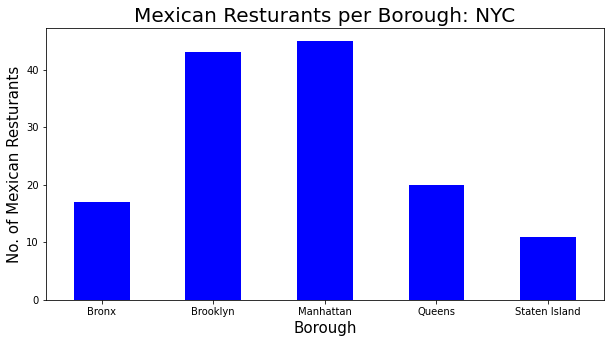

In [56]:
mexican_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Mexican Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Mexican Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Mexican restaurants per neighborhood

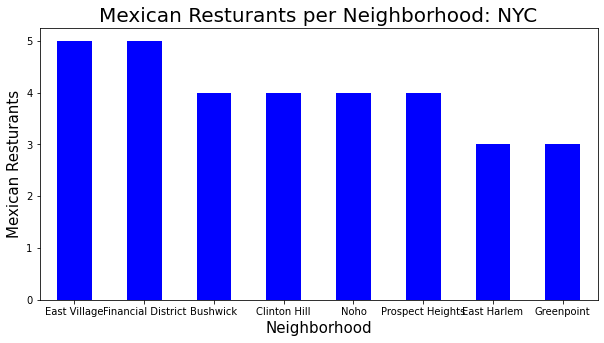

In [60]:
NOofNeigh = 8 # top number for graphing all the same past 6
mexican_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Mexican Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Mexican Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Pick out East Village, Financial District, Bushwick, and Clinton Hill

In [61]:
top_six = ['East Village', 'Financial District', 'Bushwick', 'Clinton Hill', 'Noho', 'Prospect Heights']
mexican_rest_ny[mexican_rest_ny.Neighborhood.isin(top_six)]

,Borough,Neighborhood,ID,Name
24,Brooklyn,Prospect Heights,54d407db498eca36438fc5d3,Nacho Macho Taco
25,Brooklyn,Prospect Heights,53361829498eb42538181b8d,Citrico
26,Brooklyn,Prospect Heights,5c942e786eda02002cb33180,Mexicocina Agaveria
27,Brooklyn,Prospect Heights,4b54c4adf964a5207ccb27e3,Maya Taqueria
28,Brooklyn,Bushwick,507c9d44e4b07390823b8d98,Taqueria Sofia
29,Brooklyn,Bushwick,4a79c17ef964a52093e71fe3,El Sol de Cholula
30,Brooklyn,Bushwick,54a5a765498e6b7e2ce128c8,El Kucho
31,Brooklyn,Bushwick,4dd6d110814d85e931ff48e4,Zefe's Mexican Restaurant
36,Brooklyn,Clinton Hill,42829c80f964a52053221fe3,Castros
37,Brooklyn,Clinton Hill,56086b40498e48b257697061,Chipotle Mexican Grill


Although Manhattan had the least number of neighborhoods, it does have the highest number of Mexican restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have. The neighborhood of East Village and Financial District have the highest number of Mexican restaurants of NYC and all are located in the borough of Manhattan.

Prepare Mexican restaurant stats

In [92]:
column_names=['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
mexican_rest_stats_ny=pd.DataFrame(columns = column_names)
count = 1

for row in mexican_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id =',ID)
        
        # assign 0 value for these resturants as they may have been recently opened or details does not exist in FourSquare Database
        id, name, likes, rating, tips = [0] * 5
    print('(',count,'/',len(mexican_rest_ny),')', 'processed')
    mexican_rest_stats_ny = mexican_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index = True)
    count+=1
_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '5fa9dc49334b1342c91bf067'}, 'response': {'venue': {'id': '5217dd2811d2d06ccafb77d3', 'name': 'Estrellita Poblana V', 'contact': {'phone': '7188843825', 'formattedPhone': '(718) 884-3825'}, 'location': {'address': '240 W 231st St', 'lat': 40.879687039717524, 'lng': -73.906256832975, 'labeledLatLngs': [{'label': 'display', 'lat': 40.879687039717524, 'lng': -73.906256832975}], 'postalCode': '10463', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['240 W 231st St', 'Bronx, NY 10463', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/estrellita-poblana-v/5217dd2811d2d06ccafb77d3', 'categories': [{'id': '4bf58dd8d48988d1c1941735', 'name': 'Mexican Restaurant', 'pluralName': 'Mexican Restaurants', 'shortName': 'Mexican', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/mexican_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'url': 'http://www.estrel

KeyError: 'venue'

In [93]:
mexican_rest_stats_ny.to_csv('mexican_rest_stats_ny.csv')

In [94]:
mexican_rest_stats_ny.shape

(50, 7)

In [95]:
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


Tidy up data type

In [96]:
mexican_rest_stats_ny['Likes'] = mexican_rest_stats_ny['Likes'].astype('float64')
mexican_rest_stats_ny['Tips'] = mexican_rest_stats_ny['Tips'].astype('float64')
mexican_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [97]:
mexican_rest_stats_ny.describe()

,Likes,Rating,Tips
count,50.000000,50.000000,50.000000
mean,42.500000,7.008000,18.060000
std,54.950534,2.207949,21.857059
min,0.000000,0.000000,0.000000
25%,8.250000,6.925000,3.000000
50%,21.000000,7.500000,6.000000
75%,47.500000,8.075000,32.750000
max,250.000000,9.200000,88.000000


In [98]:
mexican_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,5217dd2811d2d06ccafb77d3,Estrellita Poblana V,24.0,8.2,8.0
1,Bronx,Kingsbridge,4ce81d330f196dcb5d2b43ae,Picante Picante Mexican Restaurant,19.0,7.7,13.0
2,Bronx,Kingsbridge,553d5376498e322eb4d37a1b,Chipotle Mexican Grill,31.0,7.6,1.0
3,Bronx,Bedford Park,4bab9998f964a520c8b73ae3,OK Mr. Pancho,6.0,7.5,4.0
4,Bronx,Fordham,0,0,0.0,0.0,0.0


### Analysis

Group French restaurants by neighborhoods/boroughs

In [99]:
ny_neighborhood_stats=mexican_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Likes','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Likes','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Likes,Average Rating
21,Parkchester,131.000000,9.200000
18,North Side,26.000000,8.600000
27,Westchester Square,46.000000,8.400000
12,Greenpoint,127.333333,8.400000
4,Bushwick,36.750000,7.925000
3,Brooklyn Heights,37.500000,7.900000
15,Kingsbridge,24.666667,7.833333
22,Prospect Heights,61.750000,7.825000
14,Kensington,5.000000,7.800000
25,South Side,194.000000,7.800000


In [100]:
ny_borough_stats=mexican_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Likes','Rating']]
ny_borough_stats.columns=['Borough','Average Likes','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Borough,Average Likes,Average Rating
1,Brooklyn,47.459459,7.205405
0,Bronx,28.384615,6.446154


Visualize average score

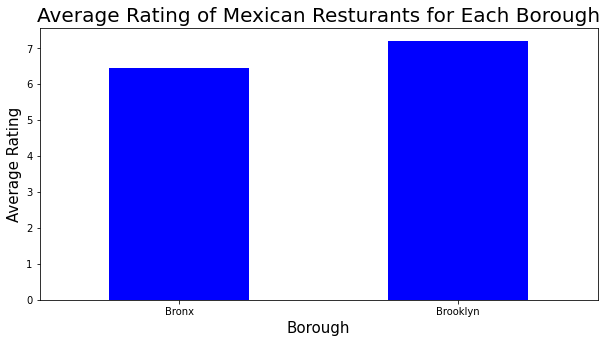

In [101]:
mexican_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average Rating of Mexican Resturants for Each Borough', fontsize=20)

plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Visually map neighborhoods with an average rating greater than or equal to 7

In [102]:
ny_neighborhood_7 = ny_neighborhood_stats[ny_neighborhood_stats['Average Rating'] >= 7.0]
ny_neighborhood_7

,Neighborhood,Average Likes,Average Rating
1,Bedford Park,6.000000,7.500000
2,Belmont,45.000000,7.300000
3,Brooklyn Heights,37.500000,7.900000
4,Bushwick,36.750000,7.925000
5,Clinton Hill,29.250000,7.300000
6,Downtown,2.000000,7.500000
8,Flatbush,17.000000,7.450000
11,Georgetown,2.000000,7.500000
12,Greenpoint,127.333333,8.400000
14,Kensington,5.000000,7.800000


In [103]:
ny_neighborhood_7 = pd.merge(ny_neighborhood_7, ny_data, on='Neighborhood')
ny_neighborhood_7 = ny_neighborhood_7[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_7

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Bedford Park,40.870185,-73.885512,7.500000
1,Bronx,Belmont,40.857277,-73.888452,7.300000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.900000
3,Brooklyn,Bushwick,40.698116,-73.925258,7.925000
4,Brooklyn,Clinton Hill,40.693229,-73.967843,7.300000
5,Brooklyn,Downtown,40.690844,-73.983463,7.500000
6,Brooklyn,Flatbush,40.636326,-73.958401,7.450000
7,Brooklyn,Georgetown,40.623845,-73.916075,7.500000
8,Brooklyn,Greenpoint,40.730201,-73.954241,8.400000
9,Brooklyn,Kensington,40.642382,-73.980421,7.800000


Create map to display

In [104]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the restaurant list
for lat, lng, in ny_neighborhood_7[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='white',
            fill_opacity=0.6
        )
    )

In [105]:
ny_neighborhood_7['Label']=ny_neighborhood_7['Neighborhood']+', '+ny_neighborhood_7['Borough']+'('+ny_neighborhood_7['Average Rating'].map(str)+')'

# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_7[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)    

# add incidents to map
ny_map.add_child(incidents)

In [106]:
ny_neighborhood_7.sort_values('Average Rating', ascending = False)

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
13,Bronx,Parkchester,40.837938,-73.856003,9.200000,"Parkchester, Bronx(9.2)"
11,Brooklyn,North Side,40.714823,-73.958809,8.600000,"North Side, Brooklyn(8.6)"
19,Bronx,Westchester Square,40.840619,-73.842194,8.400000,"Westchester Square, Bronx(8.4)"
8,Brooklyn,Greenpoint,40.730201,-73.954241,8.400000,"Greenpoint, Brooklyn(8.399999999999999)"
3,Brooklyn,Bushwick,40.698116,-73.925258,7.925000,"Bushwick, Brooklyn(7.925000000000001)"
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.900000,"Brooklyn Heights, Brooklyn(7.9)"
10,Bronx,Kingsbridge,40.881687,-73.902818,7.833333,"Kingsbridge, Bronx(7.833333333333333)"
14,Brooklyn,Prospect Heights,40.676822,-73.964859,7.825000,"Prospect Heights, Brooklyn(7.825)"
17,Brooklyn,South Side,40.710861,-73.958001,7.800000,"South Side, Brooklyn(7.8)"
9,Brooklyn,Kensington,40.642382,-73.980421,7.800000,"Kensington, Brooklyn(7.8)"
